In [1]:

!pip -q install --upgrade pip
!pip -q install jax[cpu] flax optax
!pip -q install jax jaxlib optax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 40.8 MB/s eta 0:00:00


In [2]:

# ===========================
# 0) Setup (Colab)
# ===========================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ===========================
# 1) Imports & Config
# ===========================
import os
import time
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(74321)


Loaded sections: 13 | M_FIXED: 200
Epoch   500/40000 | Total:9.130e-02 | Mass:5.327e-03 | Q:9.075e-03 | Mom:2.528e-06 | BC:1.043e-04 | Data:3.760e-01
Epoch  1000/40000 | Total:1.066e-01 | Mass:5.216e-03 | Q:5.721e-03 | Mom:1.514e-06 | BC:3.458e-04 | Data:1.462e-01
Epoch  1500/40000 | Total:5.419e-02 | Mass:5.064e-03 | Q:4.762e-03 | Mom:1.323e-06 | BC:9.061e-05 | Data:1.139e-01
Epoch  2000/40000 | Total:5.194e-02 | Mass:4.938e-03 | Q:4.564e-03 | Mom:1.480e-06 | BC:8.660e-05 | Data:1.307e-01
Epoch  2500/40000 | Total:5.547e-02 | Mass:4.857e-03 | Q:4.449e-03 | Mom:1.678e-06 | BC:1.119e-04 | Data:1.443e-01
Epoch  3000/40000 | Total:7.931e-02 | Mass:4.783e-03 | Q:4.208e-03 | Mom:2.113e-06 | BC:2.587e-04 | Data:1.756e-01
Epoch  3500/40000 | Total:4.406e-02 | Mass:4.511e-03 | Q:3.704e-03 | Mom:2.569e-06 | BC:7.980e-05 | Data:2.307e-01
Epoch  4000/40000 | Total:2.706e-02 | Mass:4.342e-03 | Q:3.122e-03 | Mom:3.015e-06 | BC:8.811e-06 | Data:2.983e-01
Epoch  4500/40000 | Total:2.863e-02 | Mass:4.

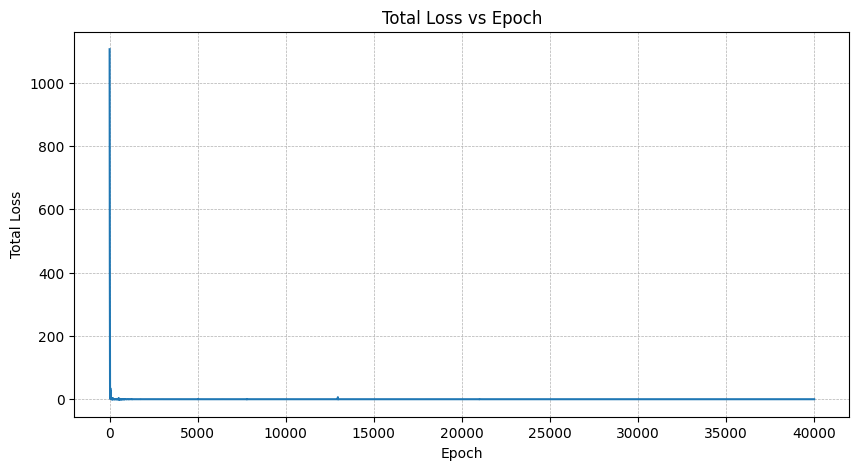

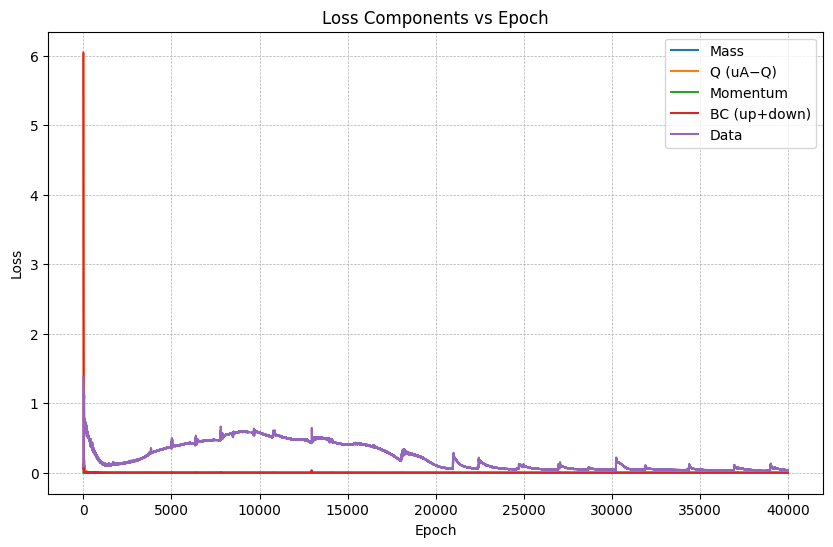

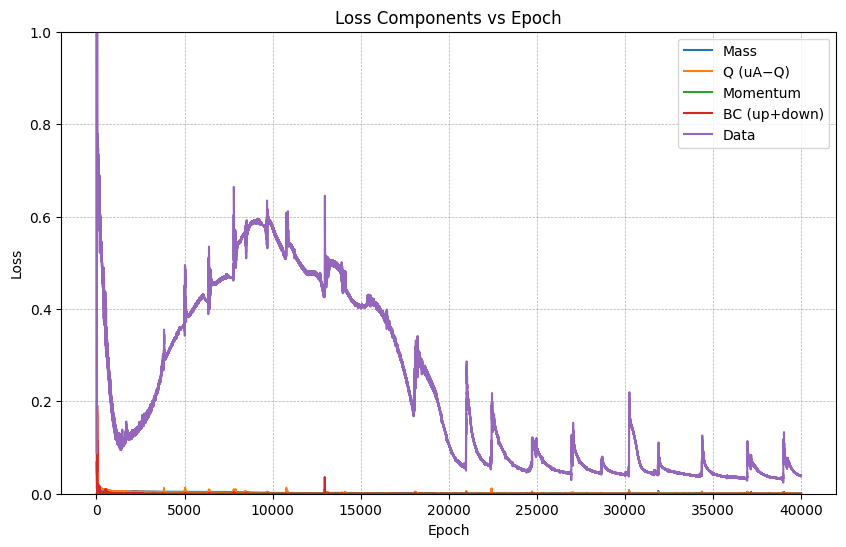

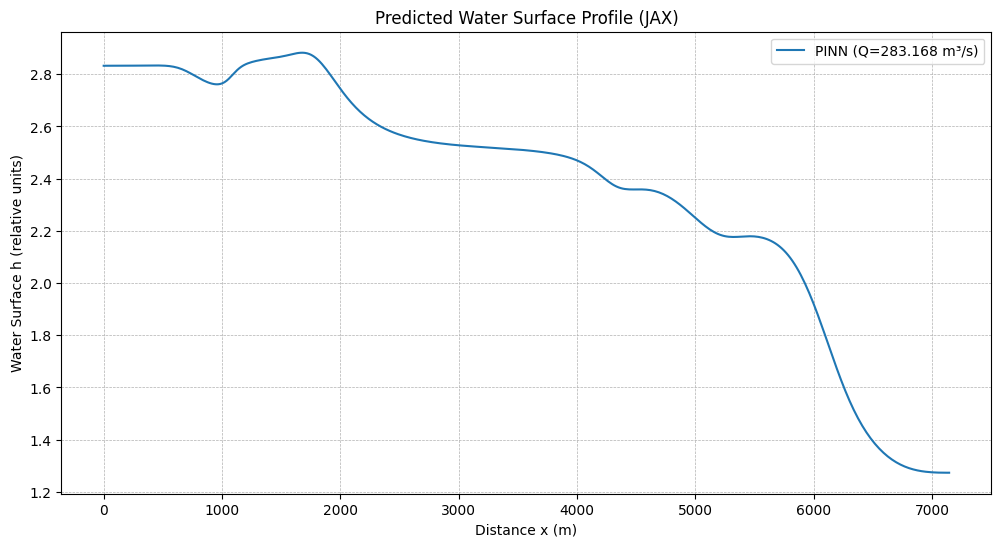

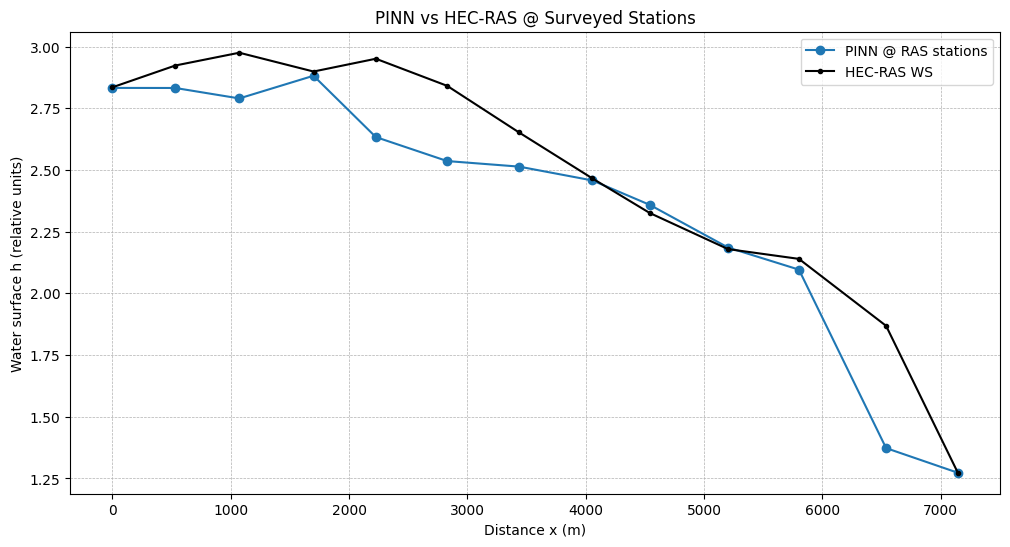

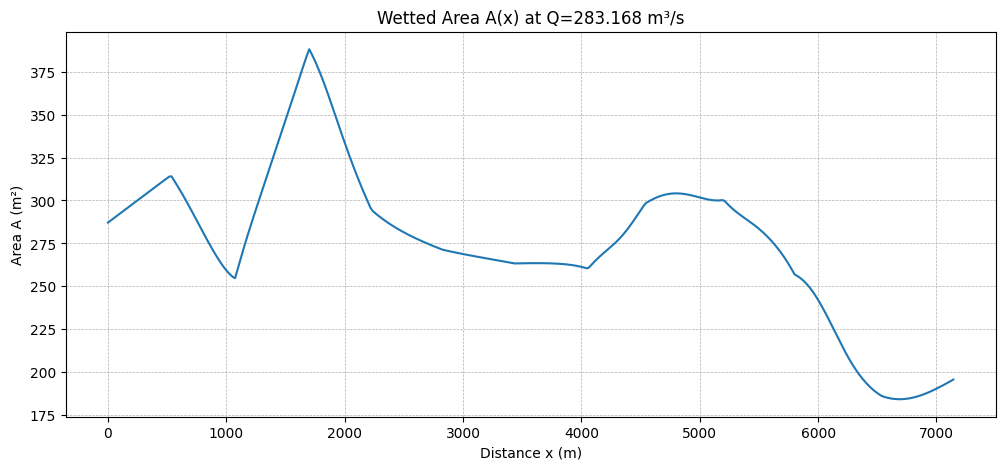

Saved: /content/h_APR_profile_Q0.csv


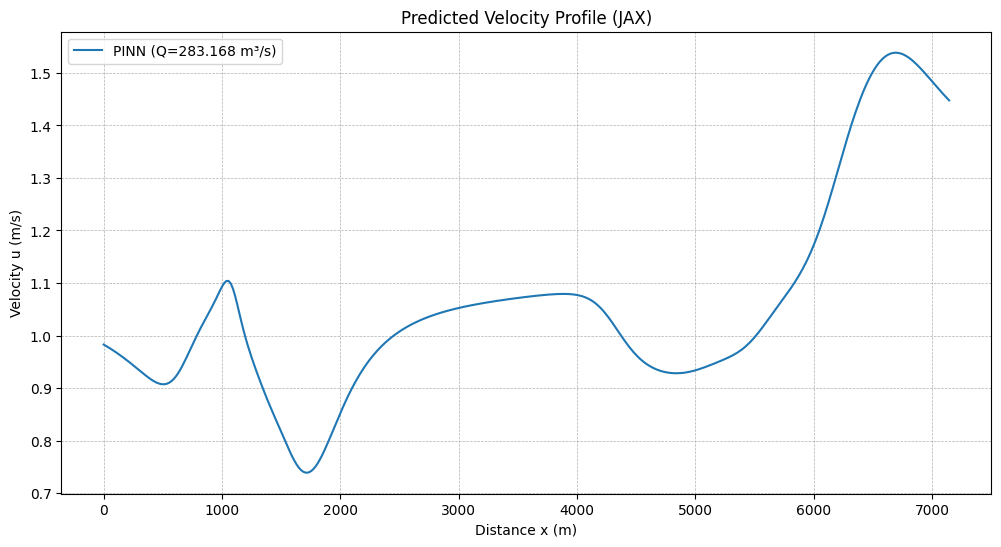

In [6]:

# ---- Physical constants ----
GRAVITY    = 9.81
MANNING_N  = 0.035  # the same as hecras channel bed, channel side a bit different
BED_SLOPE  = 0.0001864197391
Q_MIN, Q_MAX = 250.0, 300.0

# water level upstream
H_UPSTREAM = 2.83464

SINGLE_Q = True
Q0 = 283.168


# ---- PINN / training ----
NUM_COLLOCATION_POINTS = 7000
NUM_BOUNDARY_POINTS    = 100

NUM_LAYERS  = 20 #6, 70
HIDDEN_SIZE = 26  #64
LR          = 3e-4   # stable
NUM_EPOCHS  = 40000
Q_DATA = Q0



# ---- Loss Weights ----
LAMBDA_MASS     = 0.0
LAMBDA_Q        = 8.0     # let uA ≈ Q
LAMBDA_MOMENTUM = 180.0
LAMBDA_BC       = 175.0
LAMBDA_DATA     = 0.0   #

# Area Integral ：'left' | 'right' | 'midpoint' | 'simpson'
AREA_SCHEME = "simpson"

# Downsteam BC: Dirichlet（True = use water depth；False= use Sf=S0）
USE_DIRICHLET_DOWNSTREAM = True   # >>>

# ---- Cross-sections ----
DATA_DIR = '/content/drive/MyDrive/Scientific ML Project/Mid-Term Project/channel_profiles'
CS_FILES = [os.path.join(DATA_DIR, f'cs_{i:02d}_trimmed_zeroed.csv') for i in range(1, 14)]
CS_STATIONS = np.array([
    0.0, 532.36368, 1072.95696, 1700.26584, 2226.50304,
    2828.97072, 3436.83336, 4055.364, 4540.57512,
    5202.08256, 5801.04504, 6537.53328, 7142.92704
], dtype=np.float32)
CHANNEL_LENGTH = float(CS_STATIONS[-1])

# Every cross section # of sampling points
M_FIXED = 200

# ===========================
# 2) Load & Resample cross-sections
# ===========================
def resample_section(xy, M_fixed=M_FIXED):
    # xy: [M,2] with columns (x,y), x 需遞增
    x = xy[:, 0]
    y = xy[:, 1]
    x_new = jnp.linspace(x.min(), x.max(), M_fixed)
    # Linear Interpolation
    y_new = jnp.interp(x_new, x, y)
    return jnp.stack([x_new, y_new], axis=1)  # [M_fixed,2]

def load_dem_bank_resampled():
    assert len(CS_FILES) == len(CS_STATIONS)
    order = np.argsort(CS_STATIONS)
    stations_sorted = CS_STATIONS[order]
    files_sorted    = [CS_FILES[i] for i in order]
    secs = []
    for fp in files_sorted:
        df = pd.read_csv(fp)
        x = df['x_zeroed'].values.astype(np.float32)
        y = df['y_zeroed'].values.astype(np.float32)
        idx = np.argsort(x)
        xy  = jnp.array(np.stack([x[idx], y[idx]], axis=1))  # [M,2]
        secs.append(resample_section(xy, M_fixed=M_FIXED))   # [M_fixed,2]
    dem_bank_arr = jnp.stack(secs, axis=0)  # [K, M_fixed, 2]
    return dem_bank_arr, jnp.array(stations_sorted, dtype=jnp.float32)

dem_bank_arr, cs_stations = load_dem_bank_resampled()
K = dem_bank_arr.shape[0]
print("Loaded sections:", K, "| M_FIXED:", M_FIXED)


# ===========================
# 3) Load HEC-RAS water surface (for data loss & downstream BC)
# ===========================
ras_csv = '/content/drive/MyDrive/Scientific ML Project/Mid-Term Project/water_surface.csv'
ws_ras  = pd.read_csv(ras_csv)

# Relative height for h_ras and h
x_ras = jnp.array(ws_ras['cs_location'].values, dtype=jnp.float32)
h_ras = jnp.array(ws_ras['height'].values,     dtype=jnp.float32)

# Downstream Dirichlet water surface height
H_DOWNSTREAM_VAL = float(h_ras[-1])


# ===========================
# 4) MLP
# ===========================
def glorot(k, fan_in, fan_out):
    lim = jnp.sqrt(6.0/(fan_in+fan_out))
    W = jax.random.uniform(k, (fan_in, fan_out), minval=-lim, maxval=+lim)
    b = jnp.zeros((fan_out,))
    return W, b

def init_mlp(key, in_dim=2, hidden=HIDDEN_SIZE, layers=NUM_LAYERS, out_dim=2):
    keys = jax.random.split(key, layers+1)
    params = []
    # input -> hidden
    params.append(glorot(keys[0], in_dim, hidden))
    # hidden blocks
    for i in range(1, layers):
        params.append(glorot(keys[i], hidden, hidden))
    # hidden -> out
    params.append(glorot(keys[-1], hidden, out_dim))
    return params

def mlp_forward(params, x):
    # x: [N,2] (normalized)
    h = x
    for (W, b) in params[:-1]:
        h = jnp.tanh(h @ W + b)
    W, b = params[-1]
    y = h @ W + b    # [N,2] -> columns: h, u
    return y

# ===========================
# 5) Helpers: normalize & pick/interp section
# ===========================
# def normalize_xq(xq):
#     # x in [0,L] -> [-1,1];  Q in [Qmin,Qmax] -> [-1,1]
#     x = xq[:, :1]; q = xq[:, 1:2]
#     x_n = 2.0 * (x / CHANNEL_LENGTH) - 1.0
#     q_n = 2.0 * ((q - Q_MIN) / (Q_MAX - Q_MIN)) - 1.0
#     return jnp.concatenate([x_n, q_n], axis=1)
def normalize_xq(xq):
    x = xq[:, :1]; q = xq[:, 1:2]
    x_n = 2.0 * (x / CHANNEL_LENGTH) - 1.0
    if SINGLE_Q or abs(Q_MAX - Q_MIN) < 1e-9:
        q_n = jnp.zeros_like(q)      # 單一 Q → 映成 0
    else:
        q_n = 2.0 * ((q - Q_MIN) / (Q_MAX - Q_MIN)) - 1.0
    return jnp.concatenate([x_n, q_n], axis=1)


def choose_indices_linear_jax(xi, stations):
    j = jnp.searchsorted(stations, xi)
    j = jnp.clip(j, 0, stations.shape[0])
    def left_case(_):
        return 0, 0, 0.0
    def right_case(_):
        n = stations.shape[0] - 1
        return n, n, 0.0
    def mid_case(j):
        l = j - 1
        r = j
        xL = stations[l]
        xR = stations[r]
        lam = (xi - xL) / jnp.maximum(xR - xL, 1e-8)
        return l, r, lam
    return jax.lax.cond(
        j <= 0, left_case,
        lambda _: jax.lax.cond(j >= stations.shape[0], right_case, mid_case, j),
        None
    )

# ===========================
# 6) Hydraulics for sections 水利幾何計算
# ===========================


EPS   = 1e-6
MIN_A = 1e-3
MIN_P = 1e-3
MIN_R = 1e-3

def hydraulic_single_array(h_scalar, dem_xy):
    """
    dem_xy: [M,2] cross section data; h_scalar: float
    return A,P,R (scalars)
    """
    x = dem_xy[:, 0]; y = dem_xy[:, 1]
    xL, xR = x[:-1], x[1:]
    yL, yR = y[:-1], y[1:]
    dx     = xR - xL

    # Wetted Perimeter
    seg_len = jnp.sqrt((xR - xL)**2 + (yR - yL)**2)
    is_sub  = (y < h_scalar)
    seg_wet = is_sub[:-1] & is_sub[1:]
    P = jnp.sum(seg_wet * seg_len)
    P = jnp.maximum(P, MIN_P)


    # Area = ∫ max(h - y(x), 0) dx
    if AREA_SCHEME == 'left':
        A = jnp.sum(jnp.maximum(h_scalar - yL, 0.0) * dx)
    elif AREA_SCHEME == 'right':
        A = jnp.sum(jnp.maximum(h_scalar - yR, 0.0) * dx)
    elif AREA_SCHEME == 'midpoint':
        ymid = 0.5 * (yL + yR)
        A = jnp.sum(jnp.maximum(h_scalar - ymid, 0.0) * dx)

    elif AREA_SCHEME == 'simpson':
        ymid = 0.5*(yL + yR)
        Lp = jnp.maximum(h_scalar - yL,   0.0)
        Mp = jnp.maximum(h_scalar - ymid, 0.0)
        Rp = jnp.maximum(h_scalar - yR,   0.0)
        A = jnp.sum((Lp + 4*Mp + Rp)/6.0 * dx)
    else:
        raise ValueError("bad AREA_SCHEME")

    A = jnp.maximum(A, MIN_A)
    R = A / P
    R = jnp.maximum(R, MIN_R)
    return A, P, R

def hydraulics_at_x_array(h_val, x_val, mode="linear"):
    if mode == "nearest":
        j = jnp.argmin(jnp.abs(cs_stations - x_val))
        sec = jnp.take(dem_bank_arr, j, axis=0)        # [M,2]
        return hydraulic_single_array(h_val, sec)
    else:  # 'linear'
        l, r, lam = choose_indices_linear_jax(x_val, cs_stations)
        secL = jnp.take(dem_bank_arr, l, axis=0)       # [M,2]
        secR = jnp.take(dem_bank_arr, r, axis=0)       # [M,2]
        A1, P1, _ = hydraulic_single_array(h_val, secL)
        A2, P2, _ = hydraulic_single_array(h_val, secR)
        A = (1.0 - lam) * A1 + lam * A2
        P = (1.0 - lam) * P1 + lam * P2
        R = A / (P + 1e-8)
        return A, P, R

# Calculate mutiple (h,x
v_hydraulics = jax.vmap(hydraulics_at_x_array, in_axes=(0, 0, None))

# ===========================
# 7) Data: collocation & BC points（下游加密）
# ===========================
key, k1, k2, k3, k4, k5 = jax.random.split(key, 6)

N_uni = int(NUM_COLLOCATION_POINTS * 0.7)
N_dns = NUM_COLLOCATION_POINTS - N_uni

# Collocation
x_uni = jax.random.uniform(k1, (N_uni, 1), minval=0.0, maxval=CHANNEL_LENGTH)
x_dns = jax.random.uniform(k5, (N_dns, 1), minval=0.7*CHANNEL_LENGTH, maxval=CHANNEL_LENGTH)
x_c = jnp.concatenate([x_uni, x_dns], axis=0)

if SINGLE_Q:
    q_c = jnp.full((NUM_COLLOCATION_POINTS, 1), Q0)   # 全部固定成 Q0
else:
    q_uni = jax.random.uniform(k2, (N_uni, 1), minval=Q_MIN, maxval=Q_MAX)
    q_dns = jax.random.uniform(k3, (N_dns, 1), minval=Q_MIN, maxval=Q_MAX)
    q_c = jnp.concatenate([q_uni, q_dns], axis=0)

collocation = jnp.concatenate([x_c, q_c], axis=1)

# Boundary (upstream / downstream) 也固定成 Q0
x_up = jnp.zeros((NUM_BOUNDARY_POINTS, 1))
x_dn = jnp.full((NUM_BOUNDARY_POINTS, 1), CHANNEL_LENGTH)

if SINGLE_Q:
    q_up = jnp.full((NUM_BOUNDARY_POINTS, 1), Q0)
    q_dn = jnp.full((NUM_BOUNDARY_POINTS, 1), Q0)
else:
    q_up = jax.random.uniform(k4, (NUM_BOUNDARY_POINTS, 1), minval=Q_MIN, maxval=Q_MAX)
    q_dn = jax.random.uniform(k4, (NUM_BOUNDARY_POINTS, 1), minval=Q_MIN, maxval=Q_MAX)

up_pts   = jnp.concatenate([x_up, q_up], axis=1)
down_pts = jnp.concatenate([x_dn, q_dn], axis=1)


# ===========================
# 8) Init model & optimizer
# ===========================
params = init_mlp(key, in_dim=2, hidden=HIDDEN_SIZE, layers=NUM_LAYERS, out_dim=2)
opt = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(LR)
)
opt_state = opt.init(params)

# ===========================
# 9) Forward helpers & derivatives
# ===========================
# Classical Parameters
H_SCALE = 5.0   # 典型水深 ~ 0~6 m
U_SCALE = 3.0   # 典型流速 ~ 0~3 m/s

def forward_h_u(params, xq_phys):
    xq_n = normalize_xq(xq_phys)
    y = mlp_forward(params, xq_n)  # [N,2]
    raw_h = y[:, :1]
    raw_u = y[:, 1:]
    # non-negative + reasonable scale
    h = jax.nn.softplus(raw_h) * H_SCALE
    u = jax.nn.softplus(raw_u) * U_SCALE
    return h, u

# derivatives
def uA_of_x(params, x_scalar, q_scalar, mode="linear"): # Mass Loss
    xq = jnp.array([[x_scalar, q_scalar]])
    h, u = forward_h_u(params, xq)
    A, _, _ = hydraulics_at_x_array(h.squeeze(), x_scalar, mode)
    return (u.squeeze() * A)

def h_of_x(params, x_scalar, q_scalar):
    xq = jnp.array([[x_scalar, q_scalar]])
    h, _ = forward_h_u(params, xq)
    return h.squeeze()


def u_of_x(params, x_scalar, q_scalar):
    xq = jnp.array([[x_scalar, q_scalar]])
    _, u = forward_h_u(params, xq)
    return u.squeeze()

def batch_derivatives(params, xs, qs, mode="linear"):
    xs1 = xs.squeeze(-1)
    qs1 = qs.squeeze(-1)
    grad_uA_fn = jax.vmap(jax.grad(lambda x, q: uA_of_x(params, x, q, mode), argnums=0))
    grad_h_fn  = jax.vmap(jax.grad(lambda x, q: h_of_x(params, x, q),        argnums=0))
    grad_u_fn  = jax.vmap(jax.grad(lambda x, q: u_of_x(params, x, q),        argnums=0))
    duA_dx = grad_uA_fn(xs1, qs1)[:, None]
    dh_dx  = grad_h_fn(xs1,  qs1)[:, None]
    du_dx  = grad_u_fn(xs1,  qs1)[:, None]
    return duA_dx, dh_dx, du_dx

# ===========================
# 10) Losses
# ===========================
def losses(params, coll_pts, up_pts, down_pts, mode="linear"):
    x = coll_pts[:, :1]
    q = coll_pts[:, 1:2]
    h, u = forward_h_u(params, coll_pts)

    A, P, R = v_hydraulics(h.squeeze(-1), x.squeeze(-1), mode)
    A = A[:, None]; P = P[:, None]; R = R[:, None]

    duA_dx, dh_dx, du_dx = batch_derivatives(params, x, q, mode)

    # PDE Loss
    loss_mass = jnp.mean(duA_dx**2) # Steady flow - derivative of time is zero
    #loss_q    = jnp.mean((u * A - q)**2) # Discharge loss - make uA = Q

    u_phys = q / jnp.maximum(A, 1e-6)
    loss_q = jnp.mean(((u - u_phys) / (u_phys + 1e-6))**2)

    denomR = jnp.maximum(R**(2.0/3.0), 5e-2)
    Sf = (MANNING_N * u / denomR)**2   # <-- use u, not q/A
    loss_mom = jnp.mean((BED_SLOPE - Sf - dh_dx - (u/GRAVITY)*du_dx)**2)


    # Upstream BC（Dirichlet）
    h_up, _ = forward_h_u(params, up_pts)
    loss_bc_up = jnp.mean((h_up - H_UPSTREAM)**2)

    # Downstream BC
    if USE_DIRICHLET_DOWNSTREAM:
        h_dn, _   = forward_h_u(params, down_pts)
        loss_bc_dn = jnp.mean((h_dn - H_DOWNSTREAM_VAL)**2)
    else:
        h_dn, u_dn = forward_h_u(params, down_pts)
        A_d, P_d, R_d = v_hydraulics(h_dn.squeeze(-1), down_pts[:, 0], mode)
        A_d = A_d[:, None]; R_d = R_d[:, None]
        denom_d = jnp.maximum(A_d * jnp.power(R_d, 2.0/3.0), 1e-2)
        Sf_d    = (down_pts[:, 1:2] * MANNING_N / denom_d)**2
        Sf_d    = jnp.clip(Sf_d, 0.0, 1e6)
        loss_bc_dn = jnp.mean((Sf_d - BED_SLOPE)**2)

    # Data loss
    def predict_h_at_x(params, x_array, q_val):
        xq = jnp.stack([x_array, jnp.full_like(x_array, q_val)], axis=1)
        hh, _ = forward_h_u(params, xq)
        return hh.squeeze(-1)

    Q_DATA = 283.168
    h_pred_at_ras = predict_h_at_x(params, x_ras, Q_DATA)
    loss_data = jnp.mean((h_pred_at_ras - h_ras)**2)

    total = (LAMBDA_MASS * loss_mass +
             LAMBDA_Q    * loss_q +
             LAMBDA_MOMENTUM * loss_mom +
             LAMBDA_BC * (loss_bc_up + loss_bc_dn) +
             LAMBDA_DATA * loss_data)

    return total, (loss_mass, loss_q, loss_mom, loss_bc_up, loss_bc_dn, loss_data)

# ===========================
# 11) Train step (JIT)
# ===========================
def train_step(params, opt_state, coll_pts, up_pts, down_pts, mode="linear"):
    def loss_with_aux(p):
        total, parts = losses(p, coll_pts, up_pts, down_pts, mode)
        return total, parts
    (loss_val, parts), grads = jax.value_and_grad(loss_with_aux, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val, parts

train_step = jax.jit(train_step, static_argnames=('mode',))

# 11.5) Loss tracking
loss_history = {
    "total": [],
    "mass": [],
    "q": [],
    "mom": [],
    "bc_sum": [],
    "data": []
}
# ------------------------------------

# Start timer
start_time = time.time()

# ===========================
# Training loop with timing
# ===========================
for epoch in range(1, NUM_EPOCHS+1):
    params, opt_state, total, parts = train_step(
        params, opt_state, collocation, up_pts, down_pts, mode="linear"
    )

    # --- NEW: log losses every epoch ---
    m, qv, mom, bcU, bcD, dloss = [float(x) for x in parts]
    loss_history["total"].append(float(total))
    loss_history["mass"].append(m)
    loss_history["q"].append(qv)
    loss_history["mom"].append(mom)
    loss_history["bc_sum"].append(bcU + bcD)
    loss_history["data"].append(dloss)
    # -----------------------------------

    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d}/{NUM_EPOCHS} | "
              f"Total:{float(total):.3e} | Mass:{m:.3e} | Q:{qv:.3e} | "
              f"Mom:{mom:.3e} | BC:{(bcU+bcD):.3e} | Data:{dloss:.3e}")

# End timer
end_time = time.time()
elapsed = end_time - start_time

print(f"\n Total training time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

# ===========================
# 12) Loss curves
# ===========================
epochs_arr = np.arange(1, NUM_EPOCHS + 1)

# (a) Total loss
plt.figure(figsize=(10, 5))
plt.title("Total Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.plot(epochs_arr, loss_history["total"])
# If needed: plt.yscale('log')
#plt.ylim(1e-7, 1e0)
plt.show()

# (b-1) Component losses
plt.figure(figsize=(10, 6))
plt.title("Loss Components vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.plot(epochs_arr, loss_history["mass"],    label="Mass")
plt.plot(epochs_arr, loss_history["q"],       label="Q (uA−Q)")
plt.plot(epochs_arr, loss_history["mom"],     label="Momentum")
plt.plot(epochs_arr, loss_history["bc_sum"],  label="BC (up+down)")
plt.plot(epochs_arr, loss_history["data"],    label="Data")
#plt.ylim(1e-7, 1e0)
plt.legend()
# If components vary wildly: plt.yscale('log')
plt.show()

# (b-2) Component losses
plt.figure(figsize=(10, 6))
plt.title("Loss Components vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.plot(epochs_arr, loss_history["mass"],    label="Mass")
plt.plot(epochs_arr, loss_history["q"],       label="Q (uA−Q)")
plt.plot(epochs_arr, loss_history["mom"],     label="Momentum")
plt.plot(epochs_arr, loss_history["bc_sum"],  label="BC (up+down)")
plt.plot(epochs_arr, loss_history["data"],    label="Data")
plt.ylim(-1e-7, 1e0)
plt.legend()
# If components vary wildly: plt.yscale('log')
plt.show()


# ===========================
# 13) Inference & Plots
# ===========================
def predict_h_profile(params, x_array, q_val):
    xq = jnp.stack([x_array, jnp.full_like(x_array, q_val)], axis=1)
    h, _ = forward_h_u(params, xq)
    return jnp.array(h.squeeze(-1))

# PINN Result
x_plot = jnp.linspace(0.0, CHANNEL_LENGTH, 400)
h_pred = predict_h_profile(params, x_plot, 283.168)

plt.figure(figsize=(12, 6))
plt.title("Predicted Water Surface Profile (JAX)")
plt.xlabel("Distance x (m)")
plt.ylabel("Water Surface h (relative units)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.plot(np.array(x_plot), np.array(h_pred), label="PINN (Q=283.168 m³/s)")
plt.legend()
plt.show()

# Compare with HEC-RAS
h_pred_at_ras = predict_h_profile(params, x_ras, 283.168)

plt.figure(figsize=(12, 6))
plt.title("PINN vs HEC-RAS @ Surveyed Stations")
plt.xlabel("Distance x (m)")
plt.ylabel("Water surface h (relative units)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.plot(np.array(x_ras), np.array(h_pred_at_ras), 'o-', label="PINN @ RAS stations")
plt.plot(np.array(x_ras), np.array(h_ras), 'k.-', label="HEC-RAS WS")
plt.legend()
plt.show()

# ---- A1. Compute A, P, R given predicted h(x,Q) ----
def compute_APR_profile(params, x_array, q_val, mode="linear"):
    # 1) predict h at all x
    xq = jnp.stack([x_array, jnp.full_like(x_array, q_val)], axis=1)
    h, _ = forward_h_u(params, xq)              # [N,1]
    h1 = h.squeeze(-1)
    # 2) hydraulics from (h, x)
    A, P, R = v_hydraulics(h1, x_array, mode)   # each [N]
    return jnp.array(A), jnp.array(P), jnp.array(R), jnp.array(h1)

# ---- A2. Convenience: evaluate on a uniform grid and export ----
def export_h_APR_csv(params, q_val, n_points=400, csv_path="/content/h_APR_profile.csv"):
    xs = jnp.linspace(0.0, CHANNEL_LENGTH, n_points)
    A, P, R, h = compute_APR_profile(params, xs, q_val, mode="linear")
    # (optional) also compute u_phys = Q/A for comparison
    u_phys = q_val / jnp.maximum(A, 1e-6)
    # model-predicted u (so we can compare)
    xq = jnp.stack([xs, jnp.full_like(xs, q_val)], axis=1)
    _, u_pred = forward_h_u(params, xq)
    u_pred = u_pred.squeeze(-1)

    df = pd.DataFrame({
        "x_m":        np.array(xs),
        "h_m":        np.array(h),
        "A_m2":       np.array(A),
        "P_m":        np.array(P),
        "R_m":        np.array(R),
        "u_pred_mps": np.array(u_pred),
        "u_phys_mps": np.array(u_phys),
        "ratio_u_pred_over_u_phys": np.array(u_pred / np.maximum(u_phys, 1e-9))
    })
    df.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")
    return df

# Example: compute and plot A(x) and compare velocities
xs = jnp.linspace(0.0, CHANNEL_LENGTH, 400)
A, P, R, h = compute_APR_profile(params, xs, Q0)

plt.figure(figsize=(12,5))
plt.title("Wetted Area A(x) at Q=%.3f m³/s" % Q0)
plt.xlabel("Distance x (m)"); plt.ylabel("Area A (m²)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.plot(np.array(xs), np.array(A))
plt.show()

# Optional export
_ = export_h_APR_csv(params, Q0, n_points=400, csv_path="/content/h_APR_profile_Q0.csv")


def predict_u_profile(params, x_array, q_val):
    xq = jnp.stack([x_array, jnp.full_like(x_array, q_val)], axis=1)
    _, u = forward_h_u(params, xq)
    return jnp.array(u.squeeze(-1))

# Example usage
x_plot = jnp.linspace(0.0, CHANNEL_LENGTH, 400)
u_pred = predict_u_profile(params, x_plot, Q0)

plt.figure(figsize=(12,6))
plt.title("Predicted Velocity Profile (JAX)")
plt.xlabel("Distance x (m)")
plt.ylabel("Velocity u (m/s)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.plot(np.array(x_plot), np.array(u_pred), label="PINN (Q=%.3f m³/s)" % Q0)
plt.legend()
plt.show()





In [7]:
# Compute error arrays
abs_error = np.abs(np.array(h_pred_at_ras) - np.array(h_ras))
sq_error = abs_error**2

# MAE
mae = np.mean(abs_error)

# RMSE
rmse = np.sqrt(np.mean(sq_error))

# Relative L2 error
rel_L2 = np.sqrt(np.sum(sq_error)) / np.sqrt(np.sum(np.array(h_ras)**2))

print(f"MAE   = {mae:.4f} m")
print(f"RMSE  = {rmse:.4f} m")
print(f"relL2 = {rel_L2:.4%}")

MAE   = 0.1264 m
RMSE  = 0.1969 m
relL2 = 7.7659%


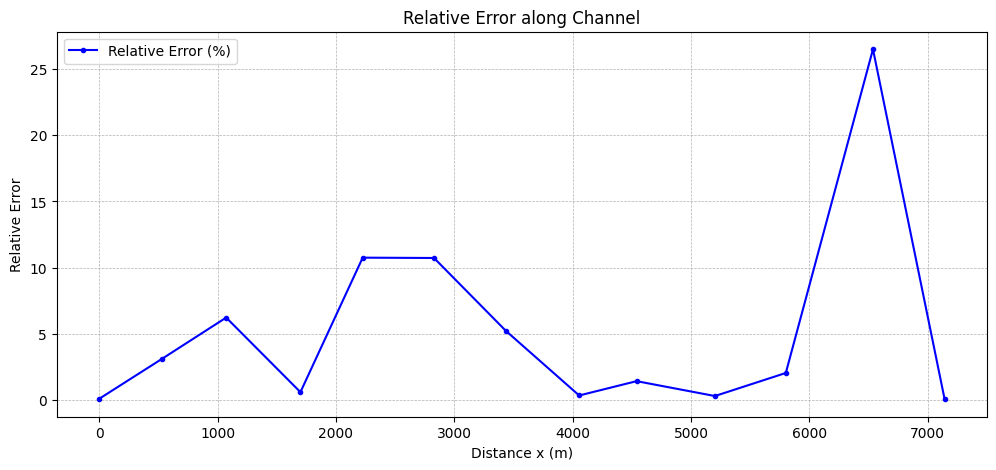

In [8]:

rel_error = abs_error / (np.array(h_ras) + 1e-6)  # avoid divide by zero

plt.figure(figsize=(12, 5))
plt.title("Relative Error along Channel")
plt.xlabel("Distance x (m)")
plt.ylabel("Relative Error")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.plot(np.array(x_ras), rel_error * 100, 'b.-', label="Relative Error (%)")
plt.legend()
plt.show()


In [9]:

import pandas as pd

error_summary = pd.DataFrame({
    "x (m)": np.array(x_ras),
    "HEC-RAS h (m)": np.array(h_ras),
    "PINN h (m)": np.array(h_pred_at_ras),
    "Abs Error (m)": abs_error,
    "Rel Error (%)": rel_error * 100
})

display(error_summary.round(3))


,x (m),HEC-RAS h (m),PINN h (m),Abs Error (m),Rel Error (%)
0,0.000000,2.835,2.832,0.002,0.083
1,532.364014,2.923,2.832,0.091,3.114
2,1072.957031,2.975,2.790,0.185,6.224
3,1700.265991,2.899,2.882,0.017,0.589
4,2226.502930,2.950,2.633,0.317,10.754
5,2828.970947,2.841,2.536,0.305,10.729
6,3436.833008,2.652,2.513,0.138,5.215
7,4055.364014,2.466,2.458,0.008,0.335
8,4540.575195,2.326,2.359,0.033,1.418
9,5202.082031,2.179,2.186,0.006,0.293
